-Naive Bayes Classifier

-Linear Support Vector Machine

-Logistic Regression

-Word2vec

-Doc2vec

-BOW

-Transformers


detection de mots mal ecrit avec fuzzywuzzy ?

In [1]:
import sys
sys.path.insert(0, '../')

from fuzzywuzzy import process
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, UnidentifiedImageError
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
from pytesseract import Output, TesseractError
import re
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score
import spacy
from tqdm.auto import tqdm
import torch

from src.features import build_features

d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Preparation

In [2]:
rvlcdip_path = "./../data/raw/selected"

#puting all the files, pictures and targets into a list
picture_list = []
target_list = []
file_list = []
for file in glob.glob(f"{rvlcdip_path}/*.tif"):
    try:
        with Image.open(file) as img:
            img_array = np.array(img) #save to a numpy array because there were too much files open otherwise.
            picture_list.append(img_array)

        target_file = file.replace(".tif", ".txt")
        with open(target_file, 'r', encoding='utf-8') as f:
            target = f.read()
            target_list.append(target)
            file_list.append(file.split('\\')[-1])
    except UnidentifiedImageError:
        print(f"Le fichier {file} n'a pas pu être ouvert.")
        continue

#stitching in a dataframe file name, picture and text
df = pd.DataFrame(columns=['filename', 'picture', 'target'])
df['filename'] = file_list
df['picture'] = picture_list
df['target'] = target_list
df['target'] = df['target'].astype(int)

#7 minutes for 20000 pictures

d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\.venv\lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Le fichier ./../data/raw/selected\2500126531_2500126536.tif n'a pas pu être ouvert.


##### Functions

In [2]:
#function to pickle a dataframe
def pickle_df(df, path):
    df.to_pickle(path)

In [3]:
#function to load a dataframe from pkl
def unpickle_df(path):
    return pd.read_pickle(path)

In [4]:
#function to ocr the pictures with pytesseract
def ocr_pytesseract(pic_series):
    ocr_text_tess_list = []
    for img_array in tqdm(pic_series):
        #transform the numpy array to a picture
        pic = Image.fromarray(img_array)
        ocr_text_tess = pytesseract.image_to_string(pic, config='--psm 3')
        ocr_text_tess = re.sub(r'\n', ' ', ocr_text_tess)
        ocr_text_tess_list.append(ocr_text_tess)

    return ocr_text_tess_list

In [5]:
#function to clean the texts
def clean_text(text):
    clean_text_list = []
    for text in tqdm(text):
        clean_text_list.append(build_features.text_cleaning(text))
    
    #building a vocabulary
    vocab = []
    for text in clean_text_list:
        vocab += text.split()
    vocab_freq = pd.Series(vocab).value_counts()
    print(f"Nombre de mots dans le vocabulaire avant suppression des moins frequents: {len(vocab_freq)}")

    #removing from the vocabulary the words that appear less than n times
    n = 2
    print(f"Suppression des mots qui apparaissent moins de {n} fois.")
    vocab_freq = vocab_freq[vocab_freq > n]
    vocab = vocab_freq.index.tolist()

    #removing all the words that are not in the vocabulary
    clean_text_list = [' '.join([word for word in text.split() if word in vocab]) for text in clean_text_list]
    print(f"Nombre de mots dans le vocabulaire apres suppression des moins frequents: {len(vocab)}")

    return clean_text_list

In [6]:
#function to resize the image
def resize_image(img_array):
    image = Image.fromarray(img_array)
    image = image.resize((1000, 1000))
    image = np.array(image)
    return image

In [7]:
#class to vectorize the text
from sklearn.base import BaseEstimator, TransformerMixin

class TextVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp = spacy.load("en_core_web_md")

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vector_text_list = []
        for text in tqdm(X):
            doc = self.nlp(text)
            vector_text_list.append(doc.vector)
        return vector_text_list

##### Preprocessing

In [9]:
#Resizing the pictures
df['picture'] = df.apply(lambda x: resize_image(x['picture']), axis=1)

#ocr with pytesseract
df['ocr_text'] = ocr_pytesseract(df.picture)

#removing extra columns
df = df.drop(columns=['filename', 'picture'], axis=1)

#cleaning the text
df['clean_text'] = clean_text(df.ocr_text)

#saving the dataframe
pickle_df(df, './../data/raw/df.pkl')
df = unpickle_df('./../data/raw/df.pkl')

#6H40 for 20000 pictures

100%|██████████| 19998/19998 [2:49:18<00:00,  1.97it/s]  


Nombre de mots dans le vocabulaire avant suppression des moins frequents: 250108
Suppression des mots qui apparaissent moins de 2 fois.
Nombre de mots dans le vocabulaire apres suppression des moins frequents: 40832


In [8]:
df = unpickle_df('./../data/raw/df.pkl')

In [9]:
#Splitting the data
X = df.clean_text
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##### Divers models

Naives Bayes Classifier

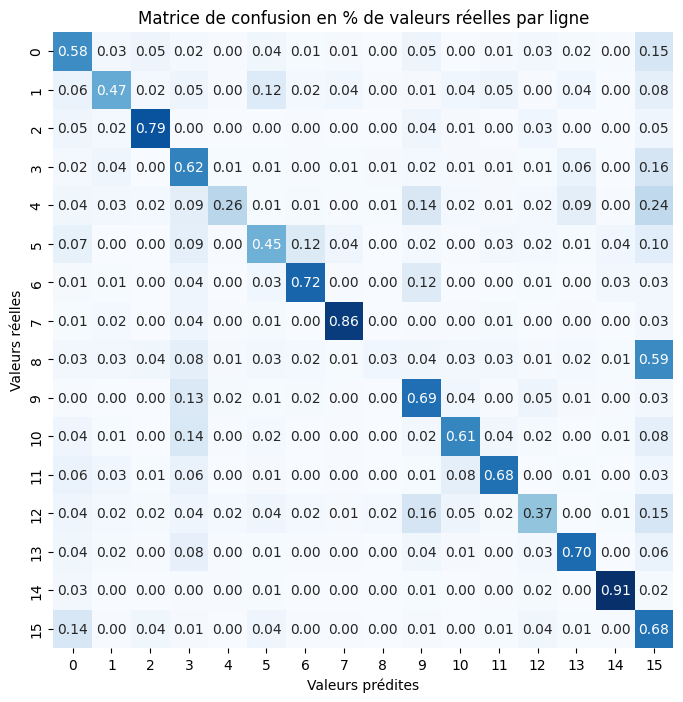

accuracy : 0.59
f1-score : 0.58


In [11]:
#implementing a naive bayes classifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

#ploting a confusion matrix and f1-score
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

print(f"accuracy : {text_clf.score(X_test, y_test):0.2f}")
print(f"f1-score : {f1_score(y_test, y_pred, average='weighted'):0.2f}")


SVM

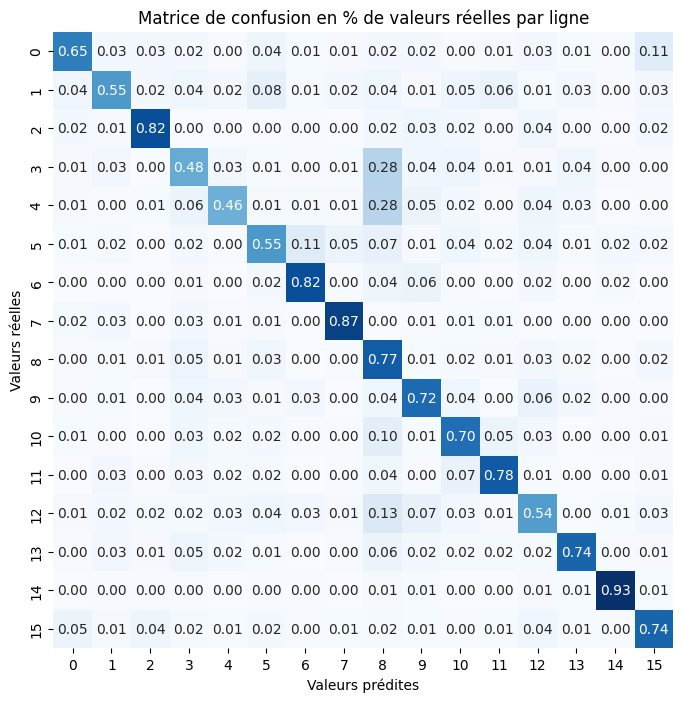

accuracy : 0.70
f1-score : 0.70


In [10]:
#implementing a linear SVC classifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer


text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LinearSVC())
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

#ploting a confusion matrix and f1-score
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

print(f"accuracy : {text_clf.score(X_test, y_test):0.2f}")
print(f"f1-score : {f1_score(y_test, y_pred, average='weighted'):0.2f}")

In [11]:
#pickling the model
import pickle

with open('./../models/svc_model.pkl', 'wb') as f:
    pickle.dump(text_clf, f)

Logistic regression

In [12]:
#implementing a logistic regression classifier
from sklearn.linear_model import LogisticRegression

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression())
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

#ploting a confusion matrix and f1-score
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

print(f"accuracy : {text_clf.score(X_test, y_test):0.2f}")
print(f"f1-score : {f1_score(y_test, y_pred, average='weighted'):0.2f}")

NameError: name 'CountVectorizer' is not defined

TF-IDF and Logistic regression classifier

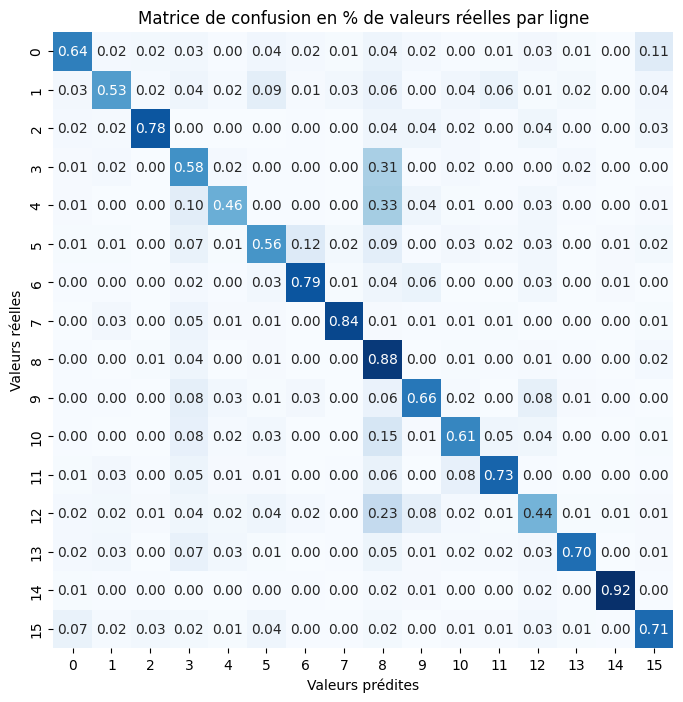

accuracy : 0.68
f1-score : 0.69


In [13]:
#implementing a tf-idf vectorizer and a logistic regression classifier
from sklearn.feature_extraction.text import TfidfVectorizer

text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

#ploting a confusion matrix and f1-score
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

print(f"accuracy : {text_clf.score(X_test, y_test):0.2f}")
print(f"f1-score : {f1_score(y_test, y_pred, average='weighted'):0.2f}")

RandomForest Classifier

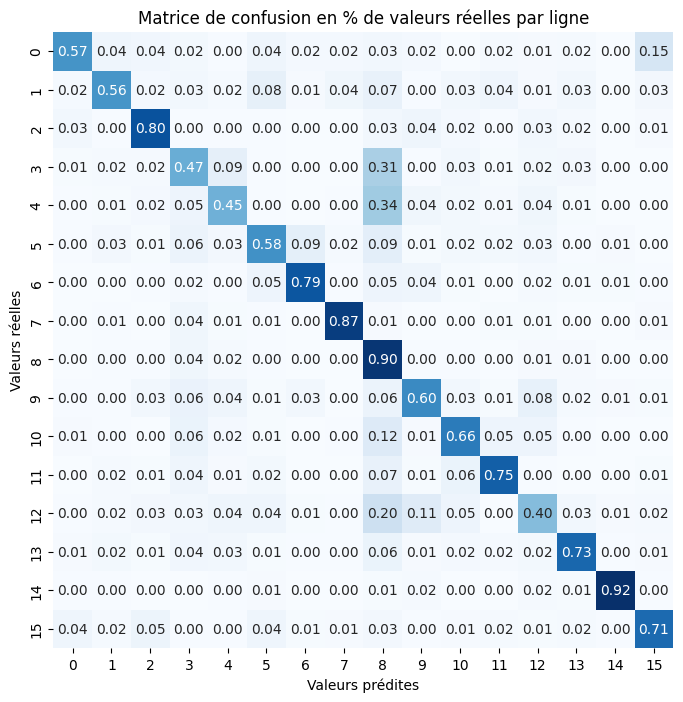

accuracy : 0.67
f1-score : 0.68


In [14]:
#implementing a random forest classifier
from sklearn.ensemble import RandomForestClassifier

text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

#ploting a confusion matrix and f1-score
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

print(f"accuracy : {text_clf.score(X_test, y_test):0.2f}")
print(f"f1-score : {f1_score(y_test, y_pred, average='weighted'):0.2f}")

In [15]:
#pickling
with open('./../models/rf_model.pkl', 'wb') as f:
    pickle.dump(text_clf, f)

In [16]:
import joblib
joblib.dump(text_clf, './../models/rf_model2.pkl', compress=3)

['./../models/rf_model2.pkl']

Gradient Boosting

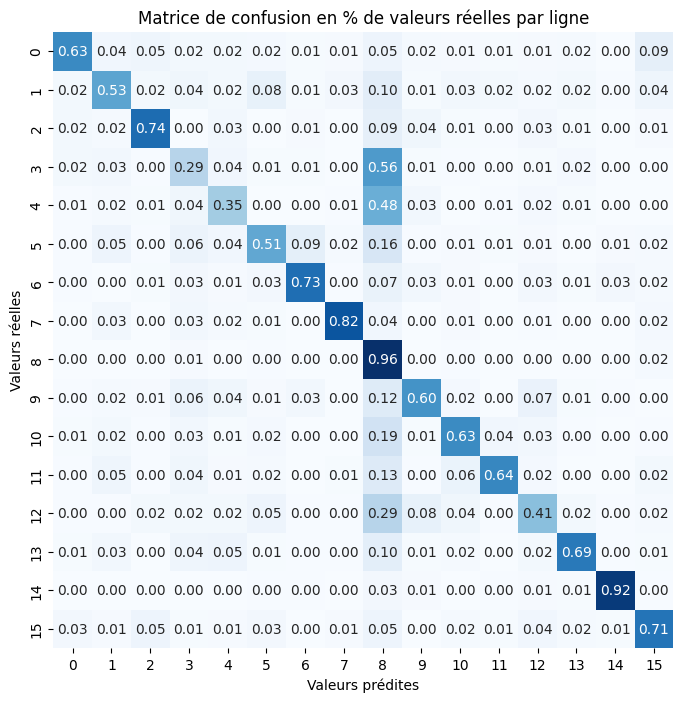

accuracy : 0.63
f1-score : 0.65


In [16]:
#implementing a gradient boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', GradientBoostingClassifier())
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

#ploting a confusion matrix and f1-score
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

print(f"accuracy : {text_clf.score(X_test, y_test):0.2f}")
print(f"f1-score : {f1_score(y_test, y_pred, average='weighted'):0.2f}")

Tf-Idf and gradient boosting

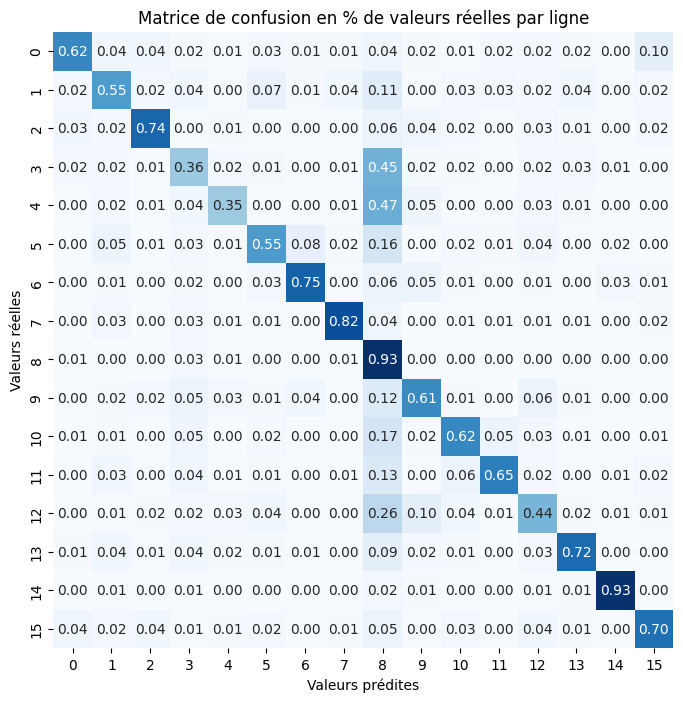

accuracy : 0.65
f1-score : 0.66


In [17]:
#implementing a tfidf classifier
from sklearn.feature_extraction.text import TfidfVectorizer

text_clf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier())
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

#ploting a confusion matrix and f1-score
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

print(f"accuracy : {text_clf.score(X_test, y_test):0.2f}")
print(f"f1-score : {f1_score(y_test, y_pred, average='weighted'):0.2f}")


Approches sémantique

100%|██████████| 15998/15998 [04:57<00:00, 53.83it/s]
d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4000/4000 [01:11<00:00, 55.56it/s]


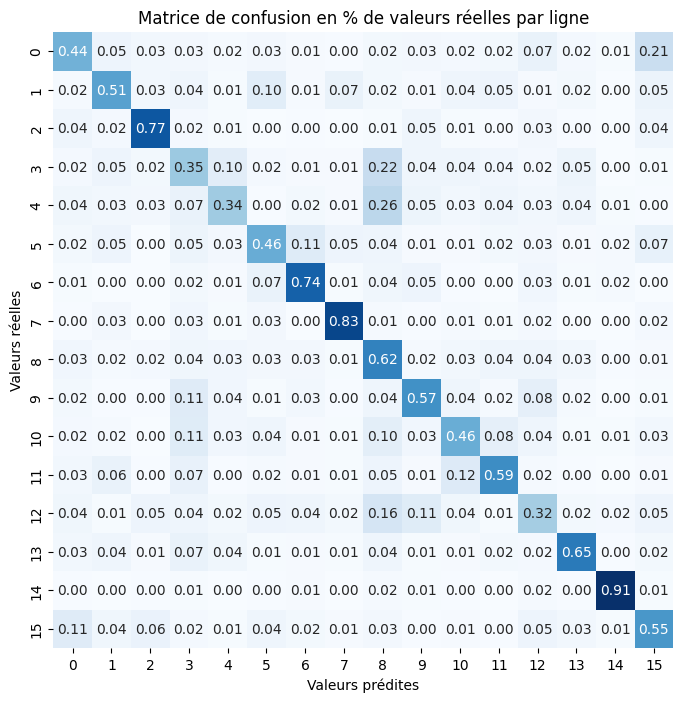

100%|██████████| 4000/4000 [01:11<00:00, 55.70it/s]

accuracy : 0.57
f1-score : 0.57


In [18]:
#implementing an embedding approach and a logistic regression classifier
text_clf = Pipeline([
    ('vect', TextVectorTransformer()),
    ('clf', LogisticRegression())
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

#ploting a confusion matrix and f1-score
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

print(f"accuracy : {text_clf.score(X_test, y_test):0.2f}")
print(f"f1-score : {f1_score(y_test, y_pred, average='weighted'):0.2f}")

doc2vec

In [19]:
#custom class for a doc2vec transformer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.base import BaseEstimator, TransformerMixin

class Doc2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, min_count=2, epochs=40):
        self.model = None
        self.vector_size = vector_size
        self.min_count = min_count
        self.epochs = epochs

    def fit(self, X, y=None):
        tagged_x = [TaggedDocument(str(row).split(), [i]) for i, row in enumerate(X)]
        model = Doc2Vec(tagged_x, vector_size=self.vector_size, min_count=self.min_count, epochs=self.epochs)
        model.train(tagged_x, total_examples=model.corpus_count, epochs=model.epochs)
        self.model = model
        return self

    def transform(self, X):
        return np.array([self.model.infer_vector(str(row).split()) for row in X])

d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


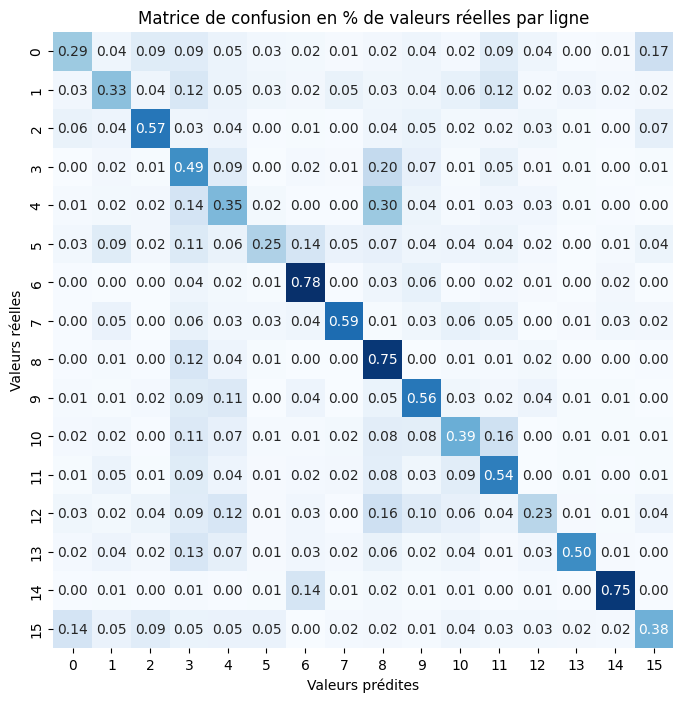

accuracy : 0.49
f1-score : 0.48


In [20]:
#implementing a doc2vec transformer and a logistic regression classifier
from sklearn.linear_model import LogisticRegression

text_clf = Pipeline([
    ('vect', Doc2VecTransformer(vector_size=300, min_count=2, epochs=40)),
    ('clf', LogisticRegression())
])

text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)

#ploting a confusion matrix and f1-score
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

print(f"accuracy : {text_clf.score(X_test, y_test):0.2f}")
print(f"f1-score : {f1_score(y_test, y_pred, average='weighted'):0.2f}")

##### Neural network

In [8]:
hidden_size = 256
LR=1e-4
epochs = 20

torch.manual_seed(0)

In [9]:
df = unpickle_df('./../data/raw/df.pkl')

In [10]:
#making a custom dataset for a neural network
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label).long()
        }

In [11]:
#making a custom classifier from pretrained Bert
from transformers import BertModel, BertTokenizer

class BertClassifier(torch.nn.Module):
    def __init__(self, bert_model_name):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        #on gele les paramètres de BERT
        for param in self.bert.parameters():
            param.requires_grad = False

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(self.bert.config.hidden_size, hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, 16)
        )
        #on degele les paramètres du classifier
        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        logits = self.classifier(pooled_output)
        return logits

In [12]:
#instancing the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
#splitting the data
X = df.clean_text
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [14]:
#creating the data loaders
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

train_dataset = TextDataset(X_train.to_list(), y_train.to_list(), tokenizer, max_length=512)
test_dataset = TextDataset(X_test.to_list(), y_test.to_list(), tokenizer, max_length=512)


train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
#instancing the model
model = BertClassifier('bert-base-uncased')

In [16]:
#instancing the loss function and the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

In [17]:
#verify that cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [18]:
#print the number of trainable parameters
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

200976


In [19]:
for epoch in tqdm(range(epochs)):
    for i, batch in tqdm(enumerate(train_dataloader)):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).squeeze()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
#42 minutes pour 5000 images et 20 epochs

  0%|          | 0/20 [00:00<?, ?it/s]d:\Users\Julien\Documents\developpement\python\mai24_bds_extraction_info\.venv\lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
1000it [13:11,  1.26it/s]
1000it [11:34,  1.44it/s]:11<4:10:32, 791.16s/it]
1000it [11:15,  1.48it/s]:46<3:40:21, 734.53s/it]
1000it [11:08,  1.49it/s]:01<3:20:27, 707.51s/it]
1000it [13:48,  1.21it/s]:10<3:04:36, 692.29s/it]
1000it [11:57,  1.39it/s]00:58<3:05:19, 741.29s/it]
1000it [11:14,  1.48it/s]12:56<2:51:06, 733.29s/it]
1000it [12:11,  1.37it/s]24:10<2:34:43, 714.10s/it]
1000it [13:43,  1.21it/s]36:21<2:23:54, 719.51s/it]
1000it [11:20,  1.47it/s]50:05<2:17:50, 751.91s/it]
1000it [11:29,  1.45it/s]:01:26<2:01:39, 730.00s/it]
1000it [12:22,  1.35it/s]:12:55<1:47:37, 717.48s/it]
1000it [13:51,

batch 1/250
batch 2/250
batch 3/250
batch 4/250
batch 5/250
batch 6/250
batch 7/250
batch 8/250
batch 9/250
batch 10/250
batch 11/250
batch 12/250
batch 13/250
batch 14/250
batch 15/250
batch 16/250
batch 17/250
batch 18/250
batch 19/250
batch 20/250
batch 21/250
batch 22/250
batch 23/250
batch 24/250
batch 25/250
batch 26/250
batch 27/250
batch 28/250
batch 29/250
batch 30/250
batch 31/250
batch 32/250
batch 33/250
batch 34/250
batch 35/250
batch 36/250
batch 37/250
batch 38/250
batch 39/250
batch 40/250
batch 41/250
batch 42/250
batch 43/250
batch 44/250
batch 45/250
batch 46/250
batch 47/250
batch 48/250
batch 49/250
batch 50/250
batch 51/250
batch 52/250
batch 53/250
batch 54/250
batch 55/250
batch 56/250
batch 57/250
batch 58/250
batch 59/250
batch 60/250
batch 61/250
batch 62/250
batch 63/250
batch 64/250
batch 65/250
batch 66/250
batch 67/250
batch 68/250
batch 69/250
batch 70/250
batch 71/250
batch 72/250
batch 73/250
batch 74/250
batch 75/250
batch 76/250
batch 77/250
batch 78

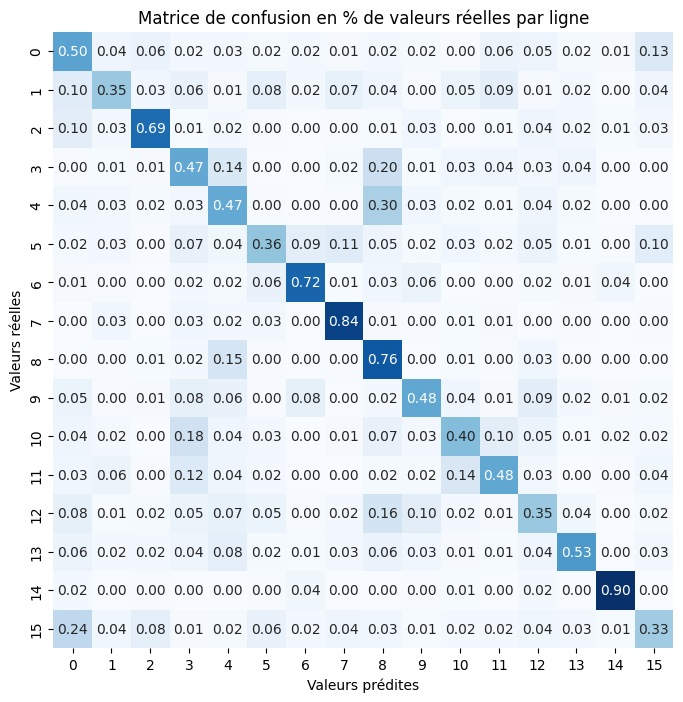

accuracy : 0.54
f1-score : 0.54


In [20]:
#getting the predictions
import torch.nn.functional as F

model.eval()
y_test = []
y_pred = []

for i, batch in enumerate(test_dataloader):
    print(f"batch {i+1}/{len(test_dataloader)}")

    y_test.extend(batch['labels'].numpy())

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    probs = F.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)
    preds = preds.cpu().numpy()
    y_pred.extend(preds)

#ploting a confusion matrix and f1-score
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de confusion en % de valeurs réelles par ligne')
plt.show()

print(f"accuracy : {np.mean(np.array(y_test) == np.array(y_pred)):0.2f}")
print(f"f1-score : {f1_score(y_test, y_pred, average='weighted'):0.2f}")


In [21]:
#clear cuda cache
torch.cuda.empty_cache()

torch.manual_seed(0)

epochs = 10
hidden_size = 64

LR=1e-5
accuracy : 0.11
f1-score : 0.05

LR=1e-4
accuracy : 0.23
f1-score : 0.18

LR=1e-3
accuracy : 0.29
f1-score : 0.25

LR=1e-2
accuracy : 0.25
f1-score : 0.17


====

epochs = 10
LR=1e-3

hidden_size = 32
accuracy : 0.26
f1-score : 0.22

hidden_size = 64
accuracy : 0.29
f1-score : 0.25

hidden_size = 128
accuracy : 0.34
f1-score : 0.29

hidden_size = 256
accuracy : 0.33
f1-score : 0.31

hidden_size = 512
accuracy : 0.35
f1-score : 0.30

====

hidden_size = 128
LR=1e-3

epochs = 10
accuracy : 0.34
f1-score : 0.29

epochs = 20
accuracy : 0.41
f1-score : 0.38

epochs = 30
accuracy : 0.38
f1-score : 0.35

epochs = 40
accuracy : 0.43
f1-score : 0.42

epochs = 50
accuracy : 0.42
f1-score : 0.41



optimal pour cette architecture:
hidden_size = 128
LR=1e-3
epochs = 20
accuracy : 0.41
f1-score : 0.38


TODO: test sur 5000 puis 20000 images

5000
hidden_size = 128
LR=1e-3
epochs = 20
accuracy : 0.48
f1-score : 0.47

hidden_size = 256
LR=1e-3
epochs = 20
torch.manual_seed(0)

epochs = 10
hidden_size = 64

LR=1e-5
accuracy : 0.11
f1-score : 0.05

LR=1e-4
accuracy : 0.23
f1-score : 0.18

LR=1e-3
accuracy : 0.29
f1-score : 0.25

LR=1e-2
accuracy : 0.25
f1-score : 0.17


====

epochs = 10
LR=1e-3

hidden_size = 32
accuracy : 0.26
f1-score : 0.22

hidden_size = 64
accuracy : 0.29
f1-score : 0.25

hidden_size = 128
accuracy : 0.34
f1-score : 0.29

hidden_size = 256
accuracy : 0.33
f1-score : 0.31

hidden_size = 512
accuracy : 0.35
f1-score : 0.30

====

hidden_size = 128
LR=1e-3

epochs = 10
accuracy : 0.34
f1-score : 0.29

epochs = 20
accuracy : 0.41
f1-score : 0.38

epochs = 30
accuracy : 0.38
f1-score : 0.35

epochs = 40
accuracy : 0.43
f1-score : 0.42

epochs = 50
accuracy : 0.42
f1-score : 0.41



optimal pour cette architecture:
hidden_size = 128
LR=1e-3
epochs = 20
accuracy : 0.41
f1-score : 0.38



TODO: test sur 5000 puis 20000 images

5000

hidden_size = 128
LR=1e-3
epochs = 20
accuracy : 0.48
f1-score : 0.47

hidden_size = 256
LR=1e-3
epochs = 20
accuracy : 0.52
f1-score : 0.51

20000

hidden_size = 256
LR=1e-3
epochs = 20
accuracy : 0.55
f1-score : 0.54

hidden_size = 256
LR=1e-4
epochs = 20